In [1]:
# Checkout www.pygimli.org for more examples
%matplotlib inline


# 2D ERT modeling and inversion


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

Create geometry definition for the modelling domain.

worldMarker=True indicates the default boundary conditions for the ERT



In [3]:
world = mt.createWorld(start=[-50, 0], end=[50, -50], layers=[-1, -8],
                       worldMarker=True)

Create some heterogeneous circular anomaly



In [4]:
block = mt.createCircle(pos=[-4.0, -5.0], radius=[1, 1.8], marker=4,
                        boundaryMarker=10, area=0.01)

In [5]:
circle = mt.createCircle(pos=[4.0, -5.0], radius=[1, 1.8], marker=5,
                        boundaryMarker=10, area=0.01)

In [6]:
poly = mt.createPolygon([(1,-4), (2,-1.5), (4,-2), (5,-2),
                         (8,-3), (5,-3.5), (3,-4.5)], isClosed=True,
                         addNodes=3, interpolate='spline', marker=5)

Merge geometry definition into a Piecewise Linear Complex (PLC)



In [7]:
geom = world + block + circle # + poly

Optional: show the geometry



(<AxesSubplot:>, None)

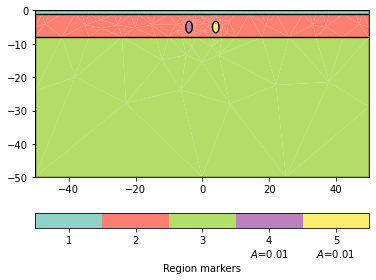

In [8]:
pg.show(geom)

Create a Dipole Dipole ('dd') measuring scheme with 21 electrodes.



In [9]:
scheme = ert.createData(elecs=np.linspace(start=-20, stop=20, num=42),
                           schemeName='dd')

Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy.



(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x1c307ff59a0>)

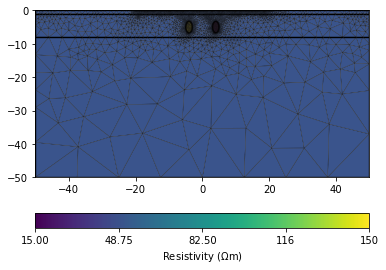

In [10]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.01])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[1, 50.],
          [2, 50.],
          [3, 50.],
          [4, 150.],
          [5, 15]]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

Perform the modeling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 1% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [11]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337, verbose=False)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

29/11/21 - 07:23:15 - pyGIMLi - INFO - 0.29294827187374417 1379.7571227859778
29/11/21 - 07:23:15 - pyGIMLi - INFO - Simulated data Data: Sensors: 42 data: 780, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
29/11/21 - 07:23:15 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
29/11/21 - 07:23:15 - pyGIMLi - INFO - Simulated rhoa (min/max) 44.872181820362094 55.08720265284357
29/11/21 - 07:23:15 - pyGIMLi - INFO - Selected data noise %(min/max) 1.0000367418238607 1.3995249661503184


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000367418238607 : 0.013995249661503185


In [12]:
# data['k']

Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



24/11/21 - 13:43:27 - pyGIMLi - INFO - Filtered rhoa (min/max) 44.872181820362094 55.08720265284357


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f7cf71bad60>)

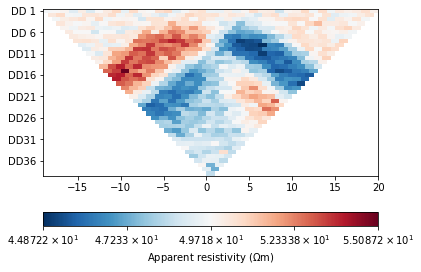

In [21]:
data.remove(data['rhoa'] < 0)
# data.remove(data['k'] < -20000.0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('simple.dat')

# You can take a look at the data
ert.show(data, cMap="RdBu_r")

Initialize the ERTManager, e.g. with a data container or a filename.



In [14]:
mgr = ert.ERTManager('simple.dat')

Run the inversion with the preset data. The Inversion mesh will be created
with default settings.



In [15]:
inv = mgr.invert(lam=10, verbose=False)
#np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

24/11/21 - 13:41:23 - pyGIMLi - INFO - Found 2 regions.
24/11/21 - 13:41:23 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/11/21 - 13:41:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/11/21 - 13:41:23 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/11/21 - 13:41:23 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/11/21 - 13:41:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/11/21 - 13:41:23 - pyGIMLi - INFO - Set default startmodel to median(data values)=49.532539205485705
24/11/21 - 13:41:23 - pyGIMLi - INFO - Created startmodel from forward operator: 633 [49.532539205485705,...,49.532539205485705]


Let the ERTManger show you the model of the last successful run and how it
fits the data. Shows data, model response, and model.



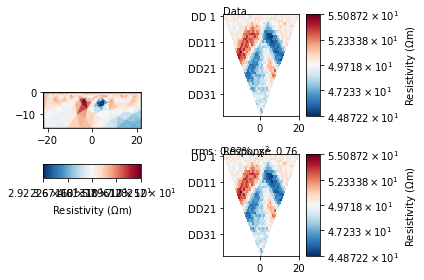

In [16]:
mgr.showResultAndFit(cMap="RdBu_r")
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

You can also provide your own mesh (e.g., a structured grid if you like them)
Note, that x and y coordinates needs to be in ascending order to ensure that
all the cells in the grid have the correct orientation, i.e., all cells need
to be numbered counter-clockwise and the boundary normal directions need to
point outside.



In [17]:
inversionDomain = pg.createGrid(x=np.linspace(start=-21, stop=21, num=43),
                                y=-pg.cat([0], pg.utils.grange(0.5, 8, n=8))[::-1],
                                marker=2)

The inversion domain for ERT problems needs a boundary that represents the
far regions in the subsurface of the halfspace.
Give a cell marker lower than the marker for the inversion region, the lowest
cell marker in the mesh will be the inversion boundary region by default.



(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f7cf18ae340>)

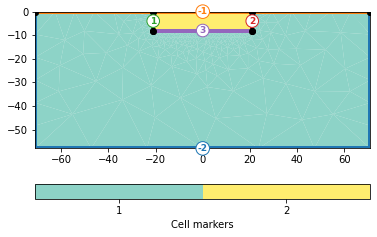

In [18]:
grid = pg.meshtools.appendTriangleBoundary(inversionDomain, marker=1,
                                           xbound=50, ybound=50)
pg.show(grid, markers=True)

#pg.show(grid, markers=True)

The Inversion can be called with data and mesh as argument as well



In [19]:
model = mgr.invert(data, mesh=grid, lam=10, verbose=False)
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.951027, significant=3)

24/11/21 - 13:41:27 - pyGIMLi - INFO - Found 2 regions.
24/11/21 - 13:41:27 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/11/21 - 13:41:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/11/21 - 13:41:27 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/11/21 - 13:41:27 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/11/21 - 13:41:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/11/21 - 13:41:27 - pyGIMLi - INFO - Set default startmodel to median(data values)=49.53253920548567
24/11/21 - 13:41:27 - pyGIMLi - INFO - Created startmodel from forward operator: 336 [49.53253920548567,...,49.53253920548567]


You can of course get access to mesh and model and plot them for your own.
Note that the cells of the parametric domain of your mesh might be in
a different order than the values in the model array if regions are used.
The manager can help to permutate them into the right order.



24/11/21 - 13:43:44 - pyGIMLi - INFO - Inversion stopped with chi² = 0.944


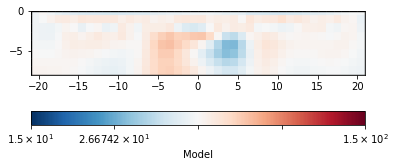

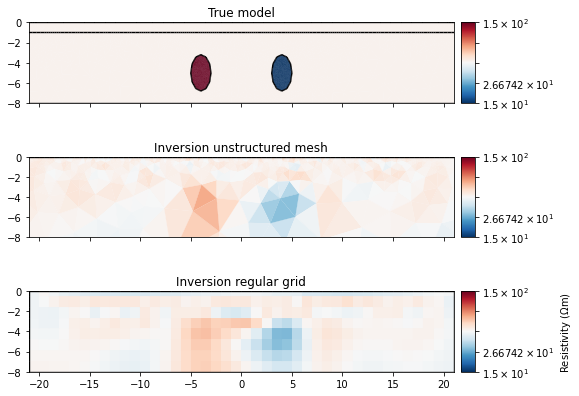

In [22]:
# np.testing.assert_approx_equal(mgr.inv.chi2(), 1.4, significant=2)

maxC = 150

modelPD = mgr.paraModel(model)  # do the mapping
pg.show(mgr.paraDomain, modelPD, label='Model', cMap='RdBu_r',
        logScale=True, cMin=15, cMax=maxC)

pg.info('Inversion stopped with chi² = {0:.3}'.format(mgr.fw.chi2()))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,7))

pg.show(mesh, rhomap, ax=ax1, hold=True, cMap="RdBu_r", logScale=True,
        orientation="vertical", cMin=15, cMax=maxC)
pg.show(meshPD, inv, ax=ax2, hold=True, cMap="RdBu_r", logScale=True,
        orientation="vertical", cMin=15, cMax=maxC)
mgr.showResult(ax=ax3, cMin=15, cMax=maxC, cMap="RdBu_r", orientation="vertical")

labels = ["True model", "Inversion unstructured mesh", "Inversion regular grid"]
for ax, label in zip([ax1, ax2, ax3], labels):
    ax.set_xlim(mgr.paraDomain.xmin(), mgr.paraDomain.xmax())
    ax.set_ylim(mgr.paraDomain.ymin(), mgr.paraDomain.ymax())
    ax.set_title(label)